In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS

from neuralforecast.losses.numpy import mae, mse

from nixtlats import TimeGPT

%matplotlib inline

In [2]:
with open("data/timegpt_api_key.txt", 'r') as file:
        API_KEY = file.read()

In [3]:
df = pd.read_csv('data/daily_min_temp.csv')
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df['unique_id'] = 0
df = df.rename(columns={"Date": "ds", "Temp": "y"})

df = df[['unique_id', 'ds', 'y']]

df.head()

,unique_id,ds,y
0,0,1981-01-01,20.7
1,0,1981-01-02,17.9
2,0,1981-01-03,18.8
3,0,1981-01-04,14.6
4,0,1981-01-05,15.8


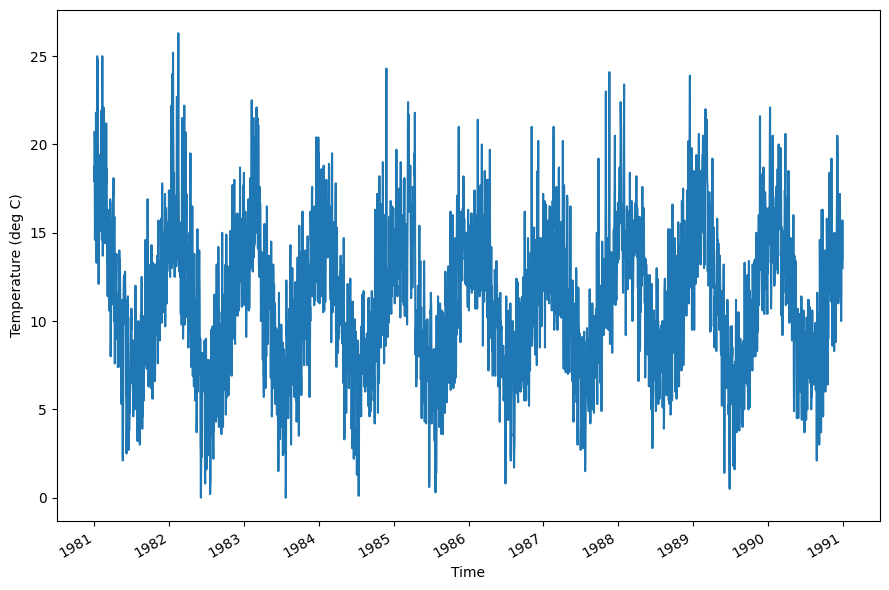

In [5]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(df['ds'], df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (deg C)')

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  3650 non-null   int64         
 1   ds         3650 non-null   datetime64[ns]
 2   y          3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 85.7 KB


## Modeling 

### TimeGPT 

In [6]:
train = df[:-365]
test = df[-365:]

print(train.shape)
print(test.shape)

(3285, 3)
(365, 3)


In [16]:
# iniitialise
timegpt = TimeGPT(token=API_KEY)

timegpt_preds_df = timegpt.forecast(df=train, h=365, finetune_steps = 10, id_col = 'unique_id', time_col ='ds', target_col='y', freq='d')

timegpt_preds_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT
0,0,1990-01-01,14.270897
1,0,1990-01-02,14.006804
2,0,1990-01-03,13.472532
3,0,1990-01-04,13.006808
4,0,1990-01-05,13.013045


### Other models 

In [10]:
horizon = 365

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=30),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=30)]

Seed set to 1
Seed set to 1


In [11]:
nf = NeuralForecast(models=models, freq='D')

In [12]:
preds_df = nf.cross_validation(df=df, step_size=horizon, n_windows=1)

2024-04-11 13:57:47.019026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
preds_df = preds_df.reset_index()
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,y,TimeGPT
0,0,1990-01-01,1989-12-31,12.189384,10.644906,14.8,14.270897
1,0,1990-01-02,1989-12-31,12.138638,9.248333,13.3,14.270897
2,0,1990-01-03,1989-12-31,12.187222,8.889777,15.6,14.270897
3,0,1990-01-04,1989-12-31,12.662315,11.131550,14.5,14.270897
4,0,1990-01-05,1989-12-31,13.150222,10.738025,14.3,14.270897


In [19]:
# Add predictions from timegpt
preds_df['TimeGPT'] = timegpt_preds_df['TimeGPT']
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,y,TimeGPT
0,0,1990-01-01,1989-12-31,12.189384,10.644906,14.8,14.270897
1,0,1990-01-02,1989-12-31,12.138638,9.248333,13.3,14.006804
2,0,1990-01-03,1989-12-31,12.187222,8.889777,15.6,13.472532
3,0,1990-01-04,1989-12-31,12.662315,11.131550,14.5,13.006808
4,0,1990-01-05,1989-12-31,13.150222,10.738025,14.3,13.013045


## Evaluation 

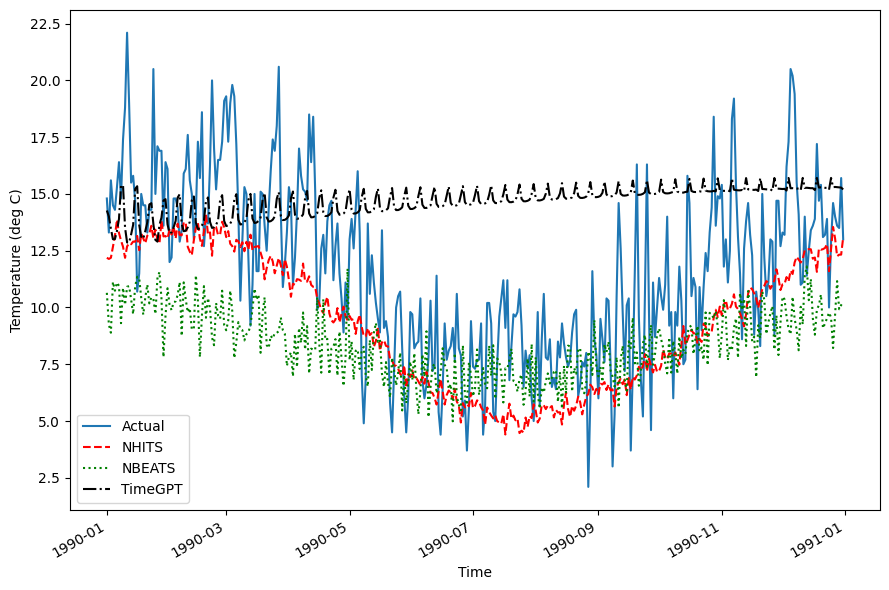

In [20]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(preds_df['ds'], preds_df['y'], label='Actual')
ax.plot(preds_df['ds'], preds_df['NHITS'], label='NHITS', ls='--', color='red')
ax.plot(preds_df['ds'], preds_df['NBEATS'], label='NBEATS', ls=':', color='green')
ax.plot(preds_df['ds'], preds_df['TimeGPT'], label='TimeGPT', ls='-.', color='black')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (deg C)')

fig.autofmt_xdate()
plt.tight_layout()

In [21]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimeGPT': [mae(preds_df['TimeGPT'], preds_df['y']), mse(preds_df['TimeGPT'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimeGPT
mae,2.771371,3.743276,4.216272
mse,11.683309,21.080379,25.844930
